In [2]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.manifold import trustworthiness
from scipy.sparse.csgraph import dijkstra
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np
import random
import queue
import json


# Antenna definitions
ASSIGNMENTS = [
	[6,2,16,18,28,5,10,14],
	[24,8,22,15,30,26,21,25],
	[3,7,1,12,0,13,31,29],
	[20,11,9,27,19,4,23,17]
]

ANTENNACOUNT = np.sum([len(antennaArray) for antennaArray in ASSIGNMENTS])

# Optimized version: Calibration constants precomputed once
def load_calibrate_timedomain(path, offset_path):
    with open(offset_path, "r") as offsetfile:
        offsets = json.load(offsetfile)

    # Precompute the calibration tensors
    fft_len = 1024
    freq_range = 2 * np.pi * np.arange(fft_len, dtype=np.float32) / fft_len
    sto_offset = tf.constant(offsets["sto"], dtype=tf.float32)[:, None] * freq_range
    cpo_offset = tf.constant(offsets["cpo"], dtype=tf.float32)[:, None]
    calib_multiplier = tf.exp(tf.complex(0.0, sto_offset + cpo_offset))

    def record_parse_function(proto):
        record = tf.io.parse_single_example(proto, {
            "csi": tf.io.FixedLenFeature([], tf.string),
            "pos-tachy": tf.io.FixedLenFeature([], tf.string),
            "time": tf.io.FixedLenFeature([], tf.float32),
        })

        csi = tf.io.parse_tensor(record["csi"], out_type=tf.float32)
        csi = tf.complex(csi[:, :, 0], csi[:, :, 1])
        csi = tf.signal.fftshift(csi, axes=1)

        position = tf.io.parse_tensor(record["pos-tachy"], out_type=tf.float64)
        time = record["time"]
        return csi, position[:2], time

    def apply_calibration(csi, pos, time):
        csi = tf.multiply(csi, calib_multiplier)
        return csi, pos, time

    def csi_time_domain(csi, pos, time):
        csi = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi, axes=1)), axes=1)
        return csi, pos, time

    def cut_out_taps(tap_start, tap_stop):
        def func(csi, pos, time):
            return csi[:, tap_start:tap_stop], pos, time
        return func

    def order_by_antenna(csi, pos, time):
        csi = tf.stack([tf.gather(csi, indices) for indices in ASSIGNMENTS])
        return csi, pos, time

    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(record_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(apply_calibration, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(csi_time_domain, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(cut_out_taps(507, 520), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(order_by_antenna, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

inputpaths = [
	{
		"tfrecords" : "dichasus/dichasus-cf02.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf02.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf03.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf03.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf04.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf04.json"
	}
]

full_dataset = load_calibrate_timedomain(inputpaths[0]["tfrecords"], inputpaths[0]["offsets"])

for path in inputpaths[1:]:
	full_dataset = full_dataset.concatenate(load_calibrate_timedomain(path["tfrecords"], path["offsets"]))


/opt/anaconda3/envs/Summer_Intern/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-04 11:35:39.967202: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-07-04 11:35:39.967227: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-07-04 11:35:39.967234: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-07-04 11:35:39.967292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-04 11:35:39.967343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB m

In [3]:
groundtruth_positions = []
csi_time_domain = []
timestamps = []
for csi, pos, time in full_dataset.batch(1000):
	csi_time_domain.append(csi.numpy())
	groundtruth_positions.append(pos.numpy())
	timestamps.append(time.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

In [4]:
csi_time_domain.shape

(83403, 4, 8, 13)

In [5]:
groundtruth_positions.shape

(83403, 2)

In [6]:
csi_time_domain[0][0][0]

array([ 3.3618109e-03-2.1445015e-04j,  6.7954545e-04+8.2021626e-04j,
        3.7861788e-03+4.2788143e-04j, -1.0474671e-03-1.0418475e-03j,
        4.5256955e-03-4.6659022e-04j,  8.1694801e-05-2.2916496e-03j,
        3.1126782e-03+3.5332050e-07j, -5.1707309e-04-5.8498781e-04j,
        1.4257961e-03-9.2701230e-05j, -1.2624456e-04-7.5024174e-04j,
        1.8147629e-03+7.5126643e-04j, -9.5525943e-04-3.4096587e-04j,
        2.5148806e-03+3.8538099e-04j], dtype=complex64)

In [22]:
def feature_extraction_F1(csi_matrix):
    csi_ifft = np.fft.ifft(csi_matrix, axis=1)
    print("Shape of csi_ifft:", csi_ifft.shape)
    R = csi_ifft * np.conj(csi_ifft)
    print("Shape of R:", R.shape)
    r = R.flatten()
    print("Shape of r:", r.shape)
    r_real = np.real(r)
    r_imag = np.imag(r)
    r_R = np.concatenate((r_real, r_imag))
    feature_vector = r_R / np.linalg.norm(r_R)
    return feature_vector
m=csi_time_domain.shape[0]
reshaped_csi = csi_time_domain.reshape(m, 32, 13)
features_F1 = np.array([feature_extraction_F1(csi) for csi in reshaped_csi])
print("Shape of Features (F1):", features_F1.shape)

Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)
Shape of r: (416,)
Shape of csi_ifft: (32, 13)
Shape of R: (32, 13)

In [20]:
reshaped_csi.shape

(83403, 32, 13)

In [9]:
import numpy as np
from scipy.special import softmax

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_soft_probability_maps(positions, grid_points, temperature=.1):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    sim_scores = -dists / temperature
    prob_maps = softmax(sim_scores, axis=1)
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30, temperature=.1):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    prob_maps = compute_soft_probability_maps(positions, grid_points, temperature=temperature)

    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points

In [16]:
def plot_heatmap(prob_map, grid_points, title="Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_map.reshape(100, 100), extent=(grid_points[:, 0].min(), grid_points[:, 0].max(),
                                                  grid_points[:, 1].min(), grid_points[:, 1].max()),
               origin='lower', cmap='hot', alpha=0.7)
    plt.colorbar(label='Probability')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train, x1, y_train, y1 = train_test_split(features_F1, groundtruth_positions, test_size=0.4, random_state=42)
X_test, X_pred, y_test, y_pred = train_test_split(x1, y1, test_size=0.5, random_state=42)

In [12]:
prob_map_test, est_locations_test, grid_points_test = generate_all_probability_maps(y_test, grid_size=100, temperature=0.1)
prob_map_train, est_locations_train, grid_points_train = generate_all_probability_maps(y_train, grid_size=100, temperature=0.1)
prob_map_pred, est_locations_pred, grid_points_pred = generate_all_probability_maps(y_pred, grid_size=100, temperature=0.1)

Position bounds: (-11.844396940444446, 1.5690753789916598) (-13.535522994174094, -2.0274375732290055)
Grid points shape: (10000, 2)
Position bounds: (-11.843998373214346, 1.60103254764672) (-13.536217458982545, -2.0219601606190896)
Grid points shape: (10000, 2)
Position bounds: (-11.840669936782943, 1.5952920376881177) (-13.534125897556667, -2.0147057487887023)
Grid points shape: (10000, 2)


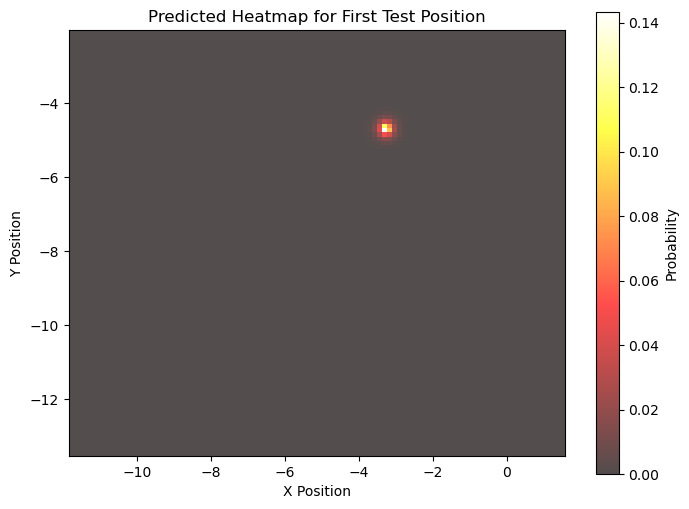

In [18]:
plot_heatmap(prob_map_train[1], grid_points_test, title="Predicted Heatmap for First Test Position")

In [14]:
from keras import layers
import tensorflow as tf

class NeuralNetwork(tf.keras.Model):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = layers.Dense(2048, input_dim=input_size,activation="gelu")
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2048,activation="gelu")
        self.bn2 = layers.BatchNormalization()
        self.fc3 = layers.Dense(2048,activation="gelu")
        self.fc4 = layers.Dense(2048,activation="gelu")
        self.fc5 = layers.Dense(2048,activation="gelu")
        self.bn5 = layers.BatchNormalization()
        self.fc6=layers.Dense(output_size,activation="softmax")


    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.bn1(x)

        x = self.fc2(x)
        x = self.bn2(x)

        x = self.fc3(x)

        x = self.fc4(x)

        x = self.fc5(x)
        x = self.bn5(x)

        x = self.fc6(x)
        return x

# Set output_size to the number of grid points (e.g., 900 for 30x30 grid)
output_size = grid_points_train.shape[0]  # grid_points from your earlier code
print(output_size)

10000


In [ ]:
import tensorflow as tf
import numpy as np

class WhiteBoxAttack:
    def __init__(
        self,
        P_model: tf.keras.Model,
        F_model: tf.keras.Model,
        W: int = 1024,
        Lp: int = 13,
        lambda_r: float = 0.0,
        step_size: float = 1e-2,
        iterations: int = 200,
        complex_dtype=tf.complex64,
    ) -> None:
        self.P = P_model
        self.F = F_model
        self.W = W
        self.Lp = Lp
        self.lambda_r = lambda_r
        self.step_size = step_size
        self.iterations = iterations
        self.cdtype = complex_dtype

    def _ifft(self, x: tf.Tensor) -> tf.Tensor:
        """Wrapper around `tf.signal.ifft` that preserves dtype."""
        return tf.signal.ifft(x)

    def _compute_rate(self, p_complex: tf.Tensor) -> tf.Tensor:
        """User‑defined spectral‑efficiency term R(p̃).

        Replace this stub with a custom implementation if a
        rate‑distortion trade‑off is required.
        """
        return tf.constant(0.0, dtype=tf.float32)

    @tf.function
    def _attack_step(
        self,
        p_real: tf.Variable,
        p_imag: tf.Variable,
        H_clean: tf.Tensor,
        x_clean: tf.Tensor,
    ) -> None:
        """One projected‑gradient ascent step."""
        with tf.GradientTape() as tape:
            p_complex = tf.complex(p_real, p_imag)

            # Project onto the unit ℓ₂ sphere
            p_complex_norm = p_complex / tf.cast(tf.norm(p_complex), self.cdtype)

            # Zero‑pad, then transform to the time domain
            padding = tf.zeros([self.W - self.Lp], dtype=self.cdtype)
            freq_vector = tf.concat([p_complex_norm, padding], axis=0)
            time_vector = self._ifft(freq_vector)  # length‑W sequence
            time_vector *= tf.sqrt(tf.cast(self.W, tf.float32))

            # Perturb the CSI (additive model – adjust for your system!)
            H_adv = H_clean + time_vector

            # Forward pass
            x_adv = self.P(self.F(H_adv))

            # Objective: maximise positioning error + λ·R
            position_loss = tf.reduce_sum(
                tf.square(tf.math.real(x_clean - x_adv))
            )
            rate_penalty = self.lambda_r * self._compute_rate(p_complex_norm)
            loss = position_loss + rate_penalty

        # Gradient ascent update
        grads = tape.gradient(loss, [p_real, p_imag])
        p_real.assign_add(self.step_size * grads[0])
        p_imag.assign_add(self.step_size * grads[1])

        # Re‑project onto the unit sphere
        p_complex_updated = tf.complex(p_real, p_imag)
        norm = tf.norm(p_complex_updated)
        p_real.assign(tf.math.real(p_complex_updated / norm))
        p_imag.assign(tf.math.imag(p_complex_updated / norm))

    # ---------------------------------------------------------------------
    # Public interface
    # ---------------------------------------------------------------------

    def generate(self, H_clean: np.ndarray):
        """Craft an adversarial CSI matrix.

        Args:
            H_clean: `np.ndarray` of shape `(W,)` or `(batch, W)` holding the
                unperturbed CSI in the frequency domain.

        Returns:
            H_adv: adversarial CSI with the same shape as `H_clean`.
            p_opt: frequency‑domain perturbation vector of length `Lp`.
        """
        H_tensor = tf.convert_to_tensor(H_clean, dtype=self.cdtype)
        x_clean = self.P(self.F(H_tensor))

        # Initialise p̃ with complex Gaussian noise
        p_real = tf.Variable(tf.random.normal([self.Lp]))
        p_imag = tf.Variable(tf.random.normal([self.Lp]))

        for _ in range(self.iterations):
            self._attack_step(p_real, p_imag, H_tensor, x_clean)

        # Compose final perturbation
        p_final = tf.complex(p_real, p_imag)
        p_final /= tf.cast(tf.norm(p_final), self.cdtype)

        padding = tf.zeros([self.W - self.Lp], dtype=self.cdtype)
        freq_vector = tf.concat([p_final, padding], axis=0)
        time_vector = self._ifft(freq_vector)
        time_vector *= tf.sqrt(tf.cast(self.W, tf.float32))

        H_adv = H_tensor + time_vector
        return H_adv.numpy(), p_final.numpy()

# -------------------------------------------------------------------------
# Example usage (replace dots with your concrete models / data)
# -------------------------------------------------------------------------
# P_model = tf.keras.models.load_model("position_network.h5")
# F_model = tf.keras.models.load_model("feature_extractor.h5")
# H_sample = np.load("csi_sample.npy")
# attack = WhiteBoxAttack(P_model, F_model, W=1024, Lp=13, lambda_r=0.05)
# H_adv, p_opt = attack.generate(H_sample)
# np.save("H_adversarial.npy", H_adv)
